# Convolutional Recurrent Neural Network for Text Recognition

To understand intuition behind this model follow these blogs: 
1. [Creating a CRNN model to recognize text in an image (Part-1)](https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-1/)
2. [Creating a CRNN model to recognize text in an image (Part-2)](https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2/)

## Introduction

An optical character recognition problem is basically a type of image-based sequence recognition problem. And for sequence recognition problem, most suited neural networks are recurrent neural networks(RNN) while for an image-based problem most suited are convolution neural networks(CNN). To cop up with the OCR problems we need to combine both of these CNN and RNN.

We can break the implementation of CRNN network into following steps:

1. Collecting Dataset
2. Preprocessing Data
3. Creating Network Architecture
4. Defining Loss Function
5. Training Model
6. Decoding Outputs from Prediction

### Imports

In [2]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.
/Users/apple/Library/Python/3.6/lib/python/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/apple/Library/Python/3.6/lib/python/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/apple/Library/Python/3.6/lib/python/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/apple/Library/Python/3.6/lib/py

In [3]:
import tensorflow as tf

#ignore warnings in the output
#tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9806237979344788871
]


### Dataset

we will use data provided by Visual Geometry Group. This is a huge dataset total of 10 GB images. Here I have used only 135000 images for the training set and 15000 images for validation dataset.

To download the dataset either you can directly download from [this link](https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth) or use the following commands to download the data and unzip.

wget https://www.robots.ox.ac.uk/~vgg/data/text/mjsynth.tar.gz
 
tar -xvzf mjsynth.tar.gz

### Preprocessing

Now we are having our dataset, to make it acceptable for our model we need to use some preprocessing. We need to preprocess both the input image and output labels. To preprocess our input image we will use followings:

1. Read the image and convert into a gray-scale image
2. Make each image of size (128,32) by using padding
3. Expand image dimension as (128,32,1) to make it compatible with the input shape of architecture
4. Normalize the image pixel values by dividing it with 255.

To preprocess the output labels use the followings:

1. Read the text from the name of the image as the image name contains text written inside the image.
2. Encode each character of a word into some numerical value by creating a function( as ‘a’:0, ‘b’:1 …….. ‘z’:26 etc ). Let    say we are having the word ‘abab’ then our encoded label would be [0,1,0,1]
3. Compute the maximum length from words and pad every output label to make it of the same size as the maximum length. This    is done to make it compatible with the output shape of our RNN architecture.

In [5]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits
print(char_list)
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


In [140]:
path = 'mjsynth/mnt/ramdisk/max/90kDICT32px'
 
# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0
 
i =1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
 
        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        # Normalize each image
        img = img/255.
        
        # get the text from the image
        txt = f_name.split('_')[1]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 150000
        if i == 150000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break

In [3]:
#print(len(training_img))

training_new = np.array(training_img)

num = np.random.randint(135)
#print(training_new[num].shape)

#print(training_new[0])

# Printing these images.
import matplotlib.pyplot as plt
img_plt = training_new[num].reshape((32,128))
plt.imshow(img_plt, cmap = 'gray')

#print(valid_img)
#print(valid_img.shape)
#print(valid_txt)
print(valid_input_length)
#print(valid_label_length)
#print(valid_orig_txt)

validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))])

validation_data_dim = np.asarray(validation_data)

#print(validation_data_dim.shape)

NameError: name 'np' is not defined

In [142]:
# pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

### Network Archtecture

This network architecture is inspired by this [paper](https://arxiv.org/pdf/1507.05717.pdf). Let’s see the steps that we used to create the architecture:

1. Input shape for our architecture having an input image of height 32 and width 128.
2. Here we used seven convolution layers of which 6 are having kernel size (3,3) and the last one is of size (2.2). And the    number of filters is increased from 64 to 512 layer by layer.
3. Two max-pooling layers are added with size (2,2) and then two max-pooling layers of size (2,1) are added to extract        features with a larger width to predict long texts.
4. Also, we used batch normalization layers after fifth and sixth convolution layers which accelerates the training       process.
5. Then we used a lambda function to squeeze the output from conv layer and make it compatible with LSTM layer.
6. Then used two Bidirectional LSTM layers each of which has 128 units. This RNN layer gives the output of size (batch_size, 31, 63). Where 63 is the total number of output classes including blank character.

In [9]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        5900

### Loss Function

Here, we are using the CTC loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC. If you want to know more about CTC( Connectionist Temporal Classification ) please follow [this blog](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing we will use the model that we have created earlier “act_model”. Let’s see the code:

In [93]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

### train the Model

To train the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model on the basis of validation loss.
In model.compile(), you can see that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier.
labels as input to the model earlier.

Now train your model on 135000 training images and 15000 validation images.

In [53]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = checkpoint


caviar


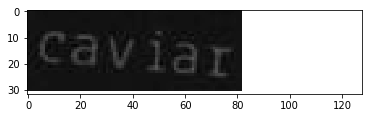

In [143]:
# converting lists to numpy arrays:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

# 
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

import matplotlib.pyplot as plt
img_plt = valid_img[0].reshape((32,128))
print(valid_orig_txt[0])
plt.imshow(img_plt, cmap = 'gray')

In [1]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

batch_size = 32
epochs = 1

#history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = [callbacks_list])


repr(history.history.values())

#print(save)

f= open('Training_success.txt','w+')
f.write(repr(history.history.values()))
f.close()



NameError: name 'Callback' is not defined

### Test the Model

Our model is now trained with 135000 images. Now its time to test the model. We can not use our training model because it also requires labels as input and at test time we can not have labels. So to test the model we will use ” act_model ” that we have created earlier which takes only one input: test images.

As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we will use the CTC decoder to get the output text. Let’s see the code:

In [2]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
num_val = 15000
# predict outputs on validation images
prediction = act_model.predict(valid_img[:num_val])
 
valid_img = np.array(valid_img)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
#print(out)
out_pred = ''
counter = 0

# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            c = char_list[int(p)]
            print(char_list[int(p)], end = '')
            out_pred= out_pred + c
    if valid_orig_txt[i] == out_pred:
        counter+=1
    out_pred = ''
    print('\n')
    i+=1
    
print('Accuracy : ', (counter/num_val)*100)

NameError: name 'act_model' is not defined